# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio
import os 
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [3]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
graph_data = data_processed + "graph_data_nohubs/"
reports_tfidf = "../../../reports/reports_nohubs/analisis_tfidf/"
reports_lsa = "../../../reports/reports_nohubs/analisis_lsa/"


graph_node_data = pd.read_csv(graph_data+"nohub_graph_node_data.csv")
graph_edge_data = pd.read_csv(graph_data+"nohub_graph_edge_data.csv").rename(columns={"relation":"edge_type"})

disease_attributes = pd.read_csv(graph_data+"nohub_disease_attributes.csv")

nodos_bert = graph_node_data.loc[graph_node_data.node_type == "bert_group",["node_index","node_id","node_name","node_source"]].copy()
disease_attributes = pd.concat([disease_attributes,nodos_bert])

enfermedades_en_dd = graph_node_data.loc[graph_node_data.degree_dd != 0, "node_index"].values
disease_attributes = disease_attributes.set_index("node_index").loc[enfermedades_en_dd].reset_index()

disease_attributes = pd.merge(graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]],disease_attributes,left_on="node_index",right_on="node_index",how="right")

# Cargo archivos

In [4]:
def load_sparse_dataframe(matrix_path,row_path,column_path,cols_str=True):
    mat = sparse.load_npz(matrix_path)
    row = np.loadtxt(row_path)
    if cols_str:
        col = np.loadtxt(column_path, dtype="str")
    else:
        col = np.loadtxt(column_path)
        
    df = pd.DataFrame.sparse.from_spmatrix(mat, index=row, columns=col)
    return df

def load_cluster_matrices(path_infomap:str,path_louvain:str):
    tfidf_infomap = []
    tfidf_louvain = []

    for i in range(3):
        mat_path = f"{path_infomap}matriz_tfidf_infomap_{i}.npz"
        row_path = f"{path_infomap}rows_tfidf_infomap_{i}.txt"
        col_path = f"{path_infomap}cols_tfidf_infomap_{i}.txt"
        
        tfidf_infomap.append(load_sparse_dataframe(mat_path,row_path,col_path))

    for i in range(3):
        mat_path = f"{path_louvain}matriz_tfidf_louvain_{i}.npz"
        row_path = f"{path_louvain}rows_tfidf_louvain_{i}.txt"
        col_path = f"{path_louvain}cols_tfidf_louvain_{i}.txt"
        
        tfidf_louvain.append(load_sparse_dataframe(mat_path,row_path,col_path))
    
    return tfidf_infomap, tfidf_louvain

def load_node_matrices(path:str):
    document_term_matrix = []
    
    for i in range(3):
        mat_path = f"{path}matriz_nodos_tfidf_{i}.npz"
        row_path = f"{path}rows_tfidf_nodos_{i}.txt"
        col_path = f"{path}cols_tfidf_nodos_{i}.txt"

        document_term_matrix.append(load_sparse_dataframe(mat_path, row_path, col_path))
    
    return document_term_matrix

def load_node_similarity_matrices(path):
    document_similarity_matrix = []
    mat_index = f"{path}similarity_matrix_index.txt"
    for i in range(3):
        mat_path = f"{path}similaridad_nodos_tfidf_{i}.npz"
        document_similarity_matrix.append(load_sparse_dataframe(mat_path,mat_index,mat_index,cols_str=False))
    
    return document_similarity_matrix

In [7]:
#Analisis previos
infomap_clusters = pd.read_pickle(reports_tfidf+"infomap_analysis_checkpoint.pkl")
louvain_clusters = pd.read_pickle(reports_tfidf+"louvain_analysis_checkpoint.pkl")

In [9]:
document_term_matrix = load_node_matrices(graph_data+"tfidf_nodos/")
infomap_dtm, louvain_dtm = load_cluster_matrices(graph_data+"tfidf_infomap/", graph_data+"tfidf_louvain/")

In [5]:
# # Document-Term-Matrix  de clusters

# path_infomap = data_processed + "tfidf_infomap/"
# path_louvain = data_processed + "tfidf_louvain/"

# monograms_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_0.npz",path_infomap + "rows_tfidf_infomap_0.txt", path_infomap+"cols_tfidf_infomap_0.txt")
# monograms_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_0.npz",path_louvain + "rows_tfidf_louvain_0.txt", path_louvain+"cols_tfidf_louvain_0.txt")

# bigrams_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_1.npz",path_infomap + "rows_tfidf_infomap_1.txt", path_infomap+"cols_tfidf_infomap_1.txt")
# bigrams_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_1.npz",path_louvain + "rows_tfidf_louvain_1.txt", path_louvain+"cols_tfidf_louvain_1.txt")

# trigrams_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_2.npz",path_infomap + "rows_tfidf_infomap_2.txt", path_infomap+"cols_tfidf_infomap_2.txt")
# trigrams_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_2.npz",path_louvain + "rows_tfidf_louvain_2.txt", path_louvain+"cols_tfidf_louvain_2.txt")

# infomap_dtm = [monograms_infomap, bigrams_infomap, trigrams_infomap]
# louvain_dtm = [monograms_louvain, bigrams_louvain, trigrams_louvain]

In [6]:
# # Document-Term-Matrix de nodos
# path = data_processed + "tfidf_nodos/"
# monograms_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_0.npz",path+"rows_tfidf_nodos_0.txt",path+"cols_tfidf_nodos_0.txt")
# bigrams_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_1.npz",path+"rows_tfidf_nodos_1.txt",path+"cols_tfidf_nodos_1.txt")
# trigrams_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_2.npz",path+"rows_tfidf_nodos_2.txt",path+"cols_tfidf_nodos_2.txt")

# document_term_matrix = [monograms_dtm, bigrams_dtm, trigrams_dtm]

In [10]:
n_components=250

# Scree plot

### Nodos

In [11]:
monograms_dtm = document_term_matrix[0]
X_nodos = monograms_dtm.sparse.to_dense()

svd = TruncatedSVD(n_components=n_components, random_state=seed)
lsa = svd.fit(X_nodos)

In [63]:
mat_index = X_nodos.index.astype(int).values

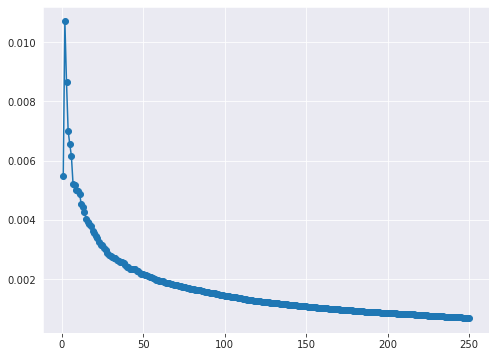

In [12]:
y = lsa.explained_variance_ratio_
x = np.linspace(1,len(y),len(y))

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,y,"o-")

In [13]:
print(f"Con {n_components} componentes tengo {round(lsa.explained_variance_ratio_.sum()*100,2)}% de varianza explicada")

Con 250 componentes tengo 42.13% de varianza explicada


Para elegir un porcentaje de varianza y sacar el corte

In [ ]:
# # con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
# evr = lsa.explained_variance_ratio_
# cant_componentes = range(1, len(evr) + 1)

# # Calculamos el acumulado con la función cumsum de numpy 
# varianza_acumulada = np.cumsum(evr)

# #Elijo un corte en 90% de varianza acumulada
# corte = np.nonzero(varianza_acumulada>0.8)[0][0]

# # Graficamos la fracción de varianza que aporta cada componente
# # y la información acumulada
# sns.set_theme()
# fig, ax = plt.subplots(figsize=(8,6))

# ax.plot(cant_componentes, varianza_acumulada, "-o")
# ax.vlines(x=cant_componentes[corte], ymax=varianza_acumulada[corte], ymin=np.min(varianza_acumulada), linestyle='--', alpha=0.5)
# ax.hlines(y=varianza_acumulada[corte], xmax=cant_componentes[corte], xmin=np.min(cant_componentes), linestyle='--', alpha=0.5)
# ax.set_xlim(xmin=-100, xmax=2000)
# ax.set_ylabel('Fracción de varianza acumulada - Nodos')
# ax.set_xlabel('Componentes')
# ax.set_title("Varianza acumlada vs número de componentes - SVD")
# print(f"Alcanzo el 80% de varianza acumlada con {corte} componentes")
# # fig.savefig(lsa_reports+"evr_plot.png")

### Clusters

In [14]:
n_components_infomap = 250
n_components_louvain = 100


X_infomap = infomap_dtm[0].sparse.to_dense()

svd_infomap = TruncatedSVD(n_components=n_components_infomap,random_state=seed)
lsa_infomap = svd_infomap.fit(X_infomap)

X_louvain = louvain_dtm[0].sparse.to_dense()

svd_louvain = TruncatedSVD(n_components=n_components_louvain, random_state=seed)
lsa_louvain = svd_louvain.fit(X_louvain)

print(f"Infomap: Con {n_components_infomap} componentes tengo {round(lsa_infomap.explained_variance_ratio_.sum()*100,2)}% de varianza explicada \n")
print(f"Louvain: Con {n_components_louvain} componentes tengo {round(lsa_louvain.explained_variance_ratio_.sum()*100,2)}% de varianza explicada \n")

Infomap: Con 250 componentes tengo 60.12% de varianza explicada 

Louvain: Con 100 componentes tengo 58.88% de varianza explicada 



In [67]:
infomap_index = X_infomap.index.astype(int).values
louvain_index = X_louvain.index.astype(int).values

Para elegir un porcentaje de varianza y sacar el corte

In [ ]:
# # con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
# evr = lsa_infomap.explained_variance_ratio_
# cant_componentes = range(1, len(evr) + 1)

# # Calculamos el acumulado con la función cumsum de numpy 
# varianza_acumulada = np.cumsum(evr)

# #Elijo un corte en 90% de varianza acumulada
# corte = np.nonzero(varianza_acumulada>0.8)[0][0]

# # Graficamos la fracción de varianza que aporta cada componente
# # y la información acumulada
# sns.set_theme()
# fig, ax = plt.subplots(figsize=(8,6))

# ax.plot(cant_componentes, varianza_acumulada, "-o")
# ax.vlines(x=cant_componentes[corte], ymax=varianza_acumulada[corte], ymin=np.min(varianza_acumulada), linestyle='--', alpha=0.5)
# ax.hlines(y=varianza_acumulada[corte], xmax=cant_componentes[corte], xmin=np.min(cant_componentes), linestyle='--', alpha=0.5)
# ax.set_xlim(xmin=-100, xmax=1000)
# ax.set_ylabel('Fracción de varianza acumulada - Clusters Infomap')
# ax.set_xlabel('Componentes')
# ax.set_title("Varianza acumlada vs número de componentes - SVD")
# print(f"Alcanzo el 90% de varianza acumlada con {corte} componentes")
# # fig.savefig(lsa_reports+"evr_plot.png")


# # con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
# evr = lsa_louvain.explained_variance_ratio_
# cant_componentes = range(1, len(evr) + 1)

# # Calculamos el acumulado con la función cumsum de numpy 
# varianza_acumulada = np.cumsum(evr)

# #Elijo un corte en 90% de varianza acumulada
# corte = np.nonzero(varianza_acumulada>0.8)[0][0]

# # Graficamos la fracción de varianza que aporta cada componente
# # y la información acumulada
# sns.set_theme()
# fig, ax = plt.subplots(figsize=(8,6))

# ax.plot(cant_componentes, varianza_acumulada, "-o")
# ax.vlines(x=cant_componentes[corte], ymax=varianza_acumulada[corte], ymin=np.min(varianza_acumulada), linestyle='--', alpha=0.5)
# ax.hlines(y=varianza_acumulada[corte], xmax=cant_componentes[corte], xmin=np.min(cant_componentes), linestyle='--', alpha=0.5)
# ax.set_xlim(xmin=-100, xmax=1000)
# ax.set_ylabel('Fracción de varianza acumulada - Clusters Louvain')
# ax.set_xlabel('Componentes')
# ax.set_title("Varianza acumlada vs número de componentes - SVD")
# print(f"Alcanzo el 90% de varianza acumlada con {corte} componentes")

Cortes para alcanzar 90% de varianza

In [ ]:
corte_infomap = 477
corte_louvain = 154

# Armo el modelo

### Clusters

In [19]:
# svd_infomap = TruncatedSVD(n_components=corte_infomap)
# lsa_infomap = svd_infomap.fit(X_infomap)
lsa_infomap_data = lsa_infomap.transform(X_infomap)

# svd_louvain = TruncatedSVD(n_components=corte_louvain)
# lsa_louvain = svd_louvain.fit(X_louvain)
lsa_louvain_data = lsa_louvain.transform(X_louvain)

In [20]:
# most important words for each topic
vocab_louvain = X_louvain.columns.values
component_data = {}

for i, comp in enumerate(lsa_louvain.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab_louvain, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

component_vocab_louvain = pd.DataFrame.from_dict(component_data,orient="index")

In [21]:
# most important words for each topic
vocab_infomap = X_infomap.columns.values
component_data = {}

for i, comp in enumerate(lsa_infomap.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab_infomap, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

component_vocab_infomap = pd.DataFrame.from_dict(component_data,orient="index")

### Nodos

In [6]:
# component_vocab = pd.read_pickle(lsa_reports+"component_vobab.pkl")
# lsa_data = sparse.load_npz(lsa_reports+"vectorized_data.npz")
# lsa_similarity_matrix = sparse.load_npz(lsa_reports+"lsa_similarity_matrix.npz")

In [15]:
# X_nodos = monograms_dtm.sparse.to_dense()

# svd = TruncatedSVD(n_components=250)
# lsa_data = svd.fit_transform(X_nodos)

lsa_data = lsa.transform(X_nodos)

In [16]:
# most important words for each topic
vocab = X_nodos.columns.values
component_data = {}

for i, comp in enumerate(svd.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

component_vocab = pd.DataFrame.from_dict(component_data,orient="index")

Guardo matrices para no tener que volver a calcularlas

In [68]:
component_vocab.to_pickle(reports_lsa+"component_vobab_nodos.pkl")
component_vocab_infomap.to_pickle(reports_lsa+"component_vocab_infomap.pkl")
component_vocab_louvain.to_pickle(reports_lsa+"component_vocab_louvain.pkl")

lsa_data_nodos_sparse = sparse.csr_matrix(lsa_data)
lsa_data_infomap_sparse = sparse.csr_matrix(lsa_infomap_data)
lsa_data_louvain_sparse = sparse.csr_matrix(lsa_louvain_data)

sparse.save_npz(reports_lsa+"lsa_node_data.npz", lsa_data_nodos_sparse)
sparse.save_npz(reports_lsa+"lsa_infomap_data.npz", lsa_data_infomap_sparse)
sparse.save_npz(reports_lsa+"lsa_louvain_data.npz", lsa_data_louvain_sparse)

np.savetxt(reports_lsa+"node_matrix_index.txt",mat_index)
np.savetxt(reports_lsa+"infomap_matrix_index.txt",infomap_index)
np.savetxt(reports_lsa+"louvain_matrix_index.txt",louvain_index)

In [52]:
sorted(zip(vocab,svd.components_[50]), key= lambda x:x[1], reverse=True)[:10]

[('breast', 0.21263813094763695),
 ('cancer', 0.2062402037966585),
 ('immunodeficiency', 0.18811893224963505),
 ('inflammation', 0.17606592934234472),
 ('glycogen', 0.15251335169240698),
 ('adrenal', 0.14800053251556824),
 ('myopathy', 0.12937057402746185),
 ('epilepsy', 0.1272528602869178),
 ('retardation', 0.12165041761440565),
 ('hereditary', 0.11615993547798288)]

### Obtengo la matriz de similaridad

In [ ]:
# lsa_data_sparse = sparse.csr_matrix(lsa_data)
# sparse.save_npz(lsa_reports+"vectorized_data.npz", lsa_data_sparse)

In [53]:
# Esta linea solo si cargué los datos como matriz sparse
# lsa_data_dense = lsa_data.toarray()

lsa_node_similarity_matrix = cosine_similarity(lsa_data,lsa_data)

Convierto a sparse y guardo

In [69]:
lsa_similarity_matrix_sparse = sparse.csr_matrix(lsa_node_similarity_matrix)
sparse.save_npz(reports_lsa+"lsa_node_similarity_matrix.npz",lsa_similarity_matrix_sparse)

## Checkpoint

In [5]:
component_vocab = pd.read_pickle(lsa_reports+"component_vobab.pkl")
lsa_data = sparse.load_npz(lsa_reports+"vectorized_data.npz")
lsa_similarity_matrix = sparse.load_npz(lsa_reports+"lsa_similarity_matrix.npz")

In [70]:
from wordcloud import WordCloud

def plot_component_vocab(component,component_vocab):
    n = component
    fig,ax = plt.subplots(figsize=(8,6))
    sns.barplot(x=component_vocab.loc[n,"wordlist"], y=component_vocab.loc[n,"scorelist"], ax=ax)
    ax.set_title(f"Top 10 términos de la componente {n}")
    plt.xticks(rotation=45)
    plt.tight_layout()

def wordcloud_component_vocab(component,component_vocab):
    n = component
    words = component_vocab.loc[n,"wordlist"]
    scores = component_vocab.loc[n,"scorelist"]
    wordcloud_dict = {word:score for (word,score) in zip(words,scores)}
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=wordcloud_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    

In [71]:
component_vocab_infomap

,wordlist,scorelist
0,"[carcinoma, neoplasm, tumor, malignant, bone, ...","[0.173, 0.17, 0.166, 0.153, 0.147, 0.147, 0.14..."
1,"[carcinoma, neoplasm, malignant, tumor, adenoc...","[0.381, 0.296, 0.288, 0.268, 0.121, 0.12, 0.12..."
2,"[infection, inflammation, fever, virus, bacter...","[0.403, 0.172, 0.147, 0.136, 0.101, 0.098, 0.0..."
3,"[muscle, dystrophy, muscular, myopathy, weakne...","[0.402, 0.292, 0.232, 0.22, 0.2, 0.133, 0.112,..."
4,"[bone, muscle, dysplasia, dystrophy, muscular,...","[0.28, 0.256, 0.234, 0.219, 0.14, 0.133, 0.12,..."
...,...,...
245,"[embryonic, lethality, nephrotic, auditory, ne...","[0.125, 0.123, 0.105, 0.083, 0.078, 0.076, 0.0..."
246,"[porokeratosis, testis, sinus, maxillary, comp...","[0.102, 0.088, 0.087, 0.08, 0.08, 0.078, 0.075..."
247,"[aneuploidy, mosaic, predisposition, prolactin...","[0.107, 0.101, 0.086, 0.079, 0.078, 0.073, 0.0..."
248,"[meningioma, chondrosarcoma, sinus, paget, max...","[0.14, 0.091, 0.089, 0.079, 0.079, 0.076, 0.07..."


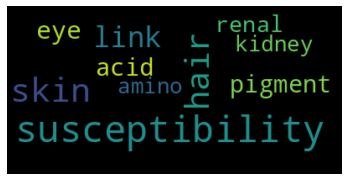

In [72]:
wordcloud_component_vocab(4,component_vocab_louvain)

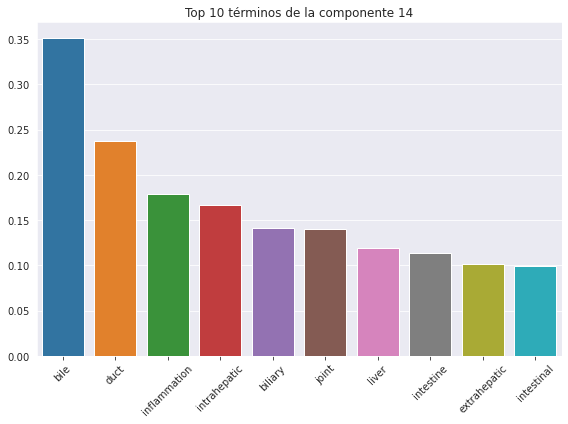

In [73]:
plot_component_vocab(14,component_vocab_infomap)

In [76]:
lsa_infomap_df = pd.DataFrame(lsa_infomap_data, index=X_infomap.index.values)
lsa_louvain_df = pd.DataFrame(lsa_louvain_data, index=X_louvain.index.values)

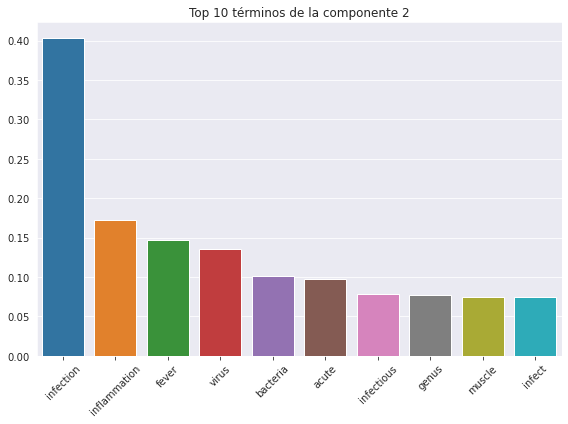

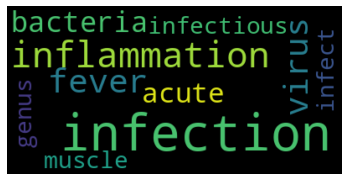

,node_index,comunidades_infomap,comunidades_louvain,node_id,node_name,disgenet_type,mondo_id,mondo_name,mondo_definition,umls_description,orphanet_definition,diseaseClassMSH,diseaseClassNameMSH,node_source
8454,25082,800.0,16.0,C0700345,"Candidiasis, Vulvovaginal",disease,6014.0,vulvovaginal candidiasis,Infection of the vulva and vagina with a fungu...,Candidiasis of the vulva and/or vagina. Infect...,NaN,C13;C01,Female Urogenital Diseases and Pregnancy Compl...,disgenet
8959,24378,800.0,16.0,C0404521,Infective vaginitis,disease,23557.0,infective vaginitis,An infectious process affecting the vagina. Sy...,A disorder characterized by an infectious proc...,NaN,C23;C13;C01,"Pathological Conditions, Signs and Symptoms; F...",disgenet
11762,21095,800.0,16.0,C0042267,Vaginitis,disease,2234.0,vaginitis (disease),A non-infectious or infectious inflammatory pr...,A non-infectious or infectious inflammatory pr...,NaN,C13,Female Urogenital Diseases and Pregnancy Compl...,disgenet
11763,21133,800.0,16.0,C0042998,Vulvovaginitis,disease,7019.0,vulvovaginitis,An inflammatory pathologic process that affect...,A non-infectious or infectious inflammatory pr...,NaN,C13,Female Urogenital Diseases and Pregnancy Compl...,disgenet
11764,21777,800.0,16.0,C0156409,Postmenopausal atrophic vaginitis,disease,1410.0,postmenopausal atrophic vaginitis,Inflammation of the vagina due to thinning of ...,Inflammation of the vagina due to thinning of ...,NaN,C13,Female Urogenital Diseases and Pregnancy Compl...,disgenet
11765,22212,800.0,16.0,C0221392,Atrophic Vaginitis,disease,1410.0,postmenopausal atrophic vaginitis,Inflammation of the vagina due to thinning of ...,Inflammation of the vagina due to thinning of ...,NaN,C13,Female Urogenital Diseases and Pregnancy Compl...,disgenet
11782,21241,800.0,16.0,C0085166,Bacterial Vaginosis,disease,5316.0,bacterial vaginosis,Infection caused by bacterial overgrowth in th...,A non-infectious or infectious inflammatory pr...,NaN,C13;C01,Female Urogenital Diseases and Pregnancy Compl...,disgenet


In [77]:
random_cluster = np.random.choice(X_infomap.index.values,1)[0]
top_component = lsa_infomap_df.loc[random_cluster].idxmax()

plot_component_vocab(top_component,component_vocab_infomap)
wordcloud_component_vocab(top_component,component_vocab_infomap)

if top_component == 0:
    second_component = lsa_infomap_df.loc[random_cluster].sort_values(ascending=False).index[1]
    plot_component_vocab(top_component,component_vocab_infomap)
    wordcloud_component_vocab(top_component,component_vocab_infomap)

disease_attributes[disease_attributes.comunidades_infomap == random_cluster]

array(['Cervical Adenosquamous Carcinoma',
       'An uncommon carcinoma arising from the cervix. It is composed of malignant glandular epithelial cells and malignant squamous epithelial cells.',
       'An uncommon carcinoma arising from the cervix. It is composed of malignant glandular epithelial cells and malignant squamous epithelial cells.',
       nan], dtype=object)

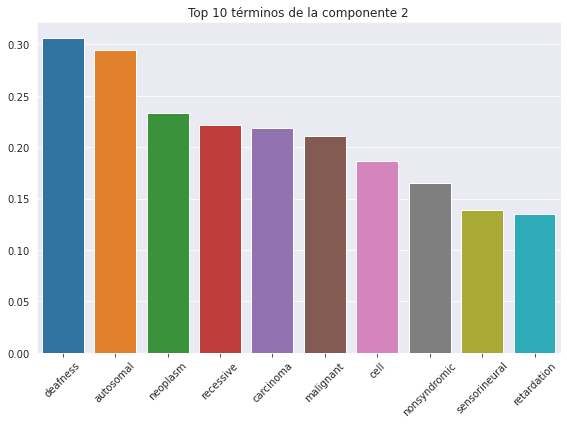

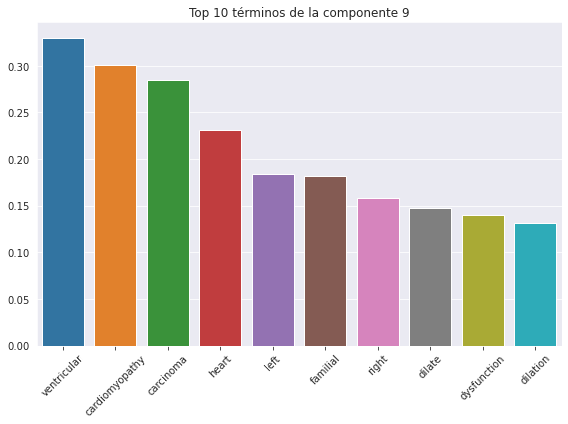

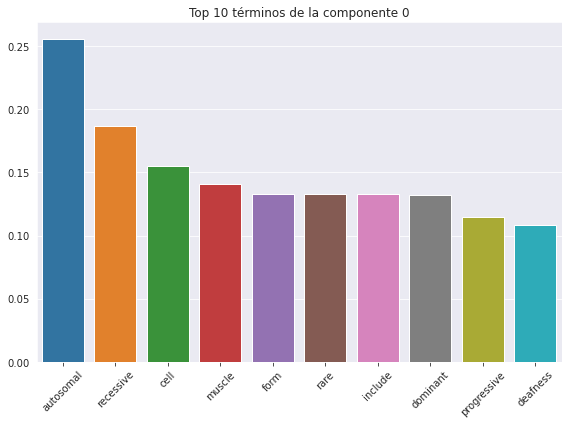

In [88]:
nodo = np.random.choice(range(lsa_data.shape[0]),1)[0]
vector_lsa = lsa_data[nodo]
top_10_components_idx = np.argsort(-vector_lsa)[0:10]
top_10_components_score = vector_lsa[top_10_components_idx]
node_data = disease_attributes.iloc[nodo][["node_name","mondo_definition","umls_description","orphanet_definition"]].values
display(node_data)
for component in top_10_components_idx[0:3]:
    plot_component_vocab(component, component_vocab)